#### Confusion Matrix for Combined Edge Defects

In [ ]:
# !pip install pickle5

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [2]:
# load test set(s) to be used
# directly from S3 (using boto3 resource)
test_key = f'processed_data/WM-clean224-thin2/WM-clean224-thin2-test.pkl'
test = pickle.loads(my_bucket.Object(test_key).get()['Body'].read())
test = test.drop(['thinMap2', 'detectLabels'], axis=1)
print(f"Test: {len(test)}")

Test: 25943


In [8]:
# load model results
with open('results_yureruns/yuclassify-224thin2-all-rotflip.pkl', "rb") as fh:
    predictions = pickle.load(fh)
y_pred = predictions[0]
test['y_pred'] = y_pred
test.head()

,ID,classifyLabels,y_pred
0,1,8,8
1,2,8,8
2,5,8,8
3,10,8,8
4,11,8,8


In [9]:
# combine EL and ER as one defect
newFailDict = {0: 'L', 1: 'E', 2: 'C', 3: 'S', 4: 'R', 5: 'NF', 6: 'D', 7: 'N'}
translator = {0: 0, 1: 1, 2: 2, 3: 1, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7}

test['y_test2'] = test.classifyLabels.apply(lambda x: translator[x])
test['y_pred2'] = test.y_pred.apply(lambda x: translator[x])

test.head()

,ID,classifyLabels,y_pred,y_test2,y_pred2
0,1,8,8,7,7
1,2,8,8,7,7
2,5,8,8,7,7
3,10,8,8,7,7
4,11,8,8,7,7


In [10]:
def plot_confusion_matrix(y_test, y_pred, mode='classify', normalize=True, figsize=(7,5)):
    """Helper function for plotting confusion matrix of model results
       Modes: detect, classify, all
       For all, assumes that none is labeled as 8"""
    
    defects = ['L', 'E', 'C', 'S', 'R', 'NF', 'D', 'N']   
    fig, ax = plt.subplots(figsize=figsize)
    
    if normalize:
        cm = confusion_matrix(y_test, y_pred, normalize='true')
        f = sns.heatmap(cm, annot=True, xticklabels=defects, yticklabels=defects)
    
    else:
        cm = confusion_matrix(y_test, y_pred, normalize=None)
        f = sns.heatmap(cm, annot=True, xticklabels=defects, yticklabels=defects, fmt='d')
        
    f.set(xlabel='Predicted Label', ylabel='True Label')

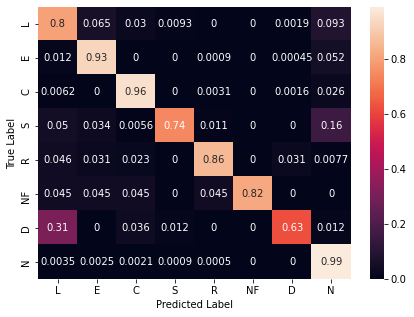

In [11]:
# plot confusion matrix
y_test = test['y_test2'].tolist()
tandem_pred = test['y_pred2'].tolist()
plot_confusion_matrix(y_test, tandem_pred, mode='all', normalize=True)

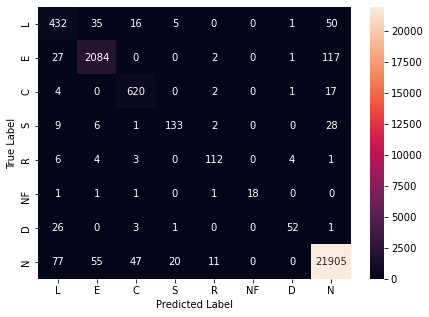

In [12]:
# plot confusion matrix counts
plot_confusion_matrix(y_test, tandem_pred, mode='all', normalize=False)

In [13]:
# manually compute overall accuracy
tandem_cm = confusion_matrix(y_test, tandem_pred)

tandem_num = 0
for i in range(8):
    tandem_num += tandem_cm[i][i]

overall_accuracy = tandem_num / len(y_test) * 100
print(f'Overall Model Accuracy: {overall_accuracy:.2f}%') 

Overall Model Accuracy: 97.74%
